In [2]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import pylab

from scipy.optimize import curve_fit, leastsq

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

sns.set_style('whitegrid')

In [3]:
df_cases_raw = pd.read_csv("./data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", index_col=False)
df_deaths_raw = pd.read_csv("./data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", index_col=False)
df_recoveries_raw = pd.read_csv("./data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv", index_col=False)

df_population_raw = pd.read_csv("./data/population_data/API_SP.POP.TOTL_DS2_en_csv_v2_887275.csv")

In [4]:
df_cases_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5


In [6]:
df_cases_grouped = df_cases_raw.groupby(by='Country/Region', as_index=False).agg('sum')
top_cases = df_cases_grouped.nlargest(10, df_cases_raw.columns[-1])['Country/Region']
print (top_cases)

165                US
82              Italy
34              China
150             Spain
63            Germany
59             France
78               Iran
169    United Kingdom
155       Switzerland
117       Netherlands
Name: Country/Region, dtype: object


In [7]:
def preprocess_frame(df):
    df = df.groupby(by='Country/Region', as_index=False).agg('sum')
    df = df.drop(['Lat', 'Long'], 1)
    df = df.set_index('Country/Region').T
    df['Date'] = df.index
    df.insert(0, 'Day', range(0, len(df)))
    df["notChina"] = df.drop(['Day', 'China', 'Date'], axis=1).sum(axis=1)
    return df

df_cases = preprocess_frame(df_cases_raw)
df_deaths = preprocess_frame(df_deaths_raw)
df_recoveries = preprocess_frame(df_recoveries_raw)

df_population = df_population_raw[["Country Name", "2018"]]

In [9]:
print ("Mortality rates")
print ("---------------")
for country in top_cases:
    print (country, ": ", round(float(df_deaths[country][-1])/float(df_cases[country][-1])*100, 3), "%")
    
    
print ("\nPopulation percentage infected")
print ("---------------")
for country in top_cases:
    country_pop = country
    if country == "US":
        country_pop = "United States"
    if country == "Iran":
        country_pop = "Iran, Islamic Rep."
    if country == "Korea, South":
        country_pop = "Korea, Rep."
    print (country, 
    ": ", round(float(df_cases[country][-1])/float(df_population[df_population["Country Name"]==country_pop]["2018"])*100, 3), "%")

print ("\nPopulation permil dead")
print ("---------------")
for country in top_cases:
    country_pop = country
    if country == "US":
        country_pop = "United States"
    if country == "Iran":
        country_pop = "Iran, Islamic Rep."
    if country == "Korea, South":
        country_pop = "Korea, Rep."
    print (country, ": ", round(float(df_deaths[country][-1])/float(df_population[df_population["Country Name"]==country_pop]["2018"])*1000, 5), "permil")

Mortality rates
---------------
US :  1.668 %
Italy :  10.839 %
China :  4.023 %
Spain :  8.168 %
Germany :  0.75 %
France :  6.081 %
Iran :  7.109 %
United Kingdom :  5.898 %
Switzerland :  1.876 %
Netherlands :  6.518 %

Population percentage infected
---------------
US :  0.037 %
Italy :  0.153 %
China :  0.006 %
Spain :  0.157 %
Germany :  0.07 %
France :  0.057 %
Iran :  0.043 %
United Kingdom :  0.026 %
Switzerland :  0.165 %
Netherlands :  0.057 %

Population permil dead
---------------
US :  0.00619 permil
Italy :  0.16586 permil
China :  0.00237 permil
Spain :  0.12803 permil
Germany :  0.00522 permil
France :  0.03459 permil
Iran :  0.03077 permil
United Kingdom :  0.01536 permil
Switzerland :  0.031 permil
Netherlands :  0.03714 permil


In [10]:
def shift_to_day_zero(df, df_reference):
    for key in df.columns:
        if key!= 'Date' and key!='Day' :
            if df_reference[key].sum()>0:
                df[key] = df[key].shift(-df_reference['Day'][df_reference[key]>0].iloc[0])
    

df_cases_reference = df_cases.copy()
shift_to_day_zero(df_cases, df_cases_reference)
shift_to_day_zero(df_deaths, df_cases_reference)
shift_to_day_zero(df_recoveries, df_cases_reference)

<IPython.core.display.Javascript object>


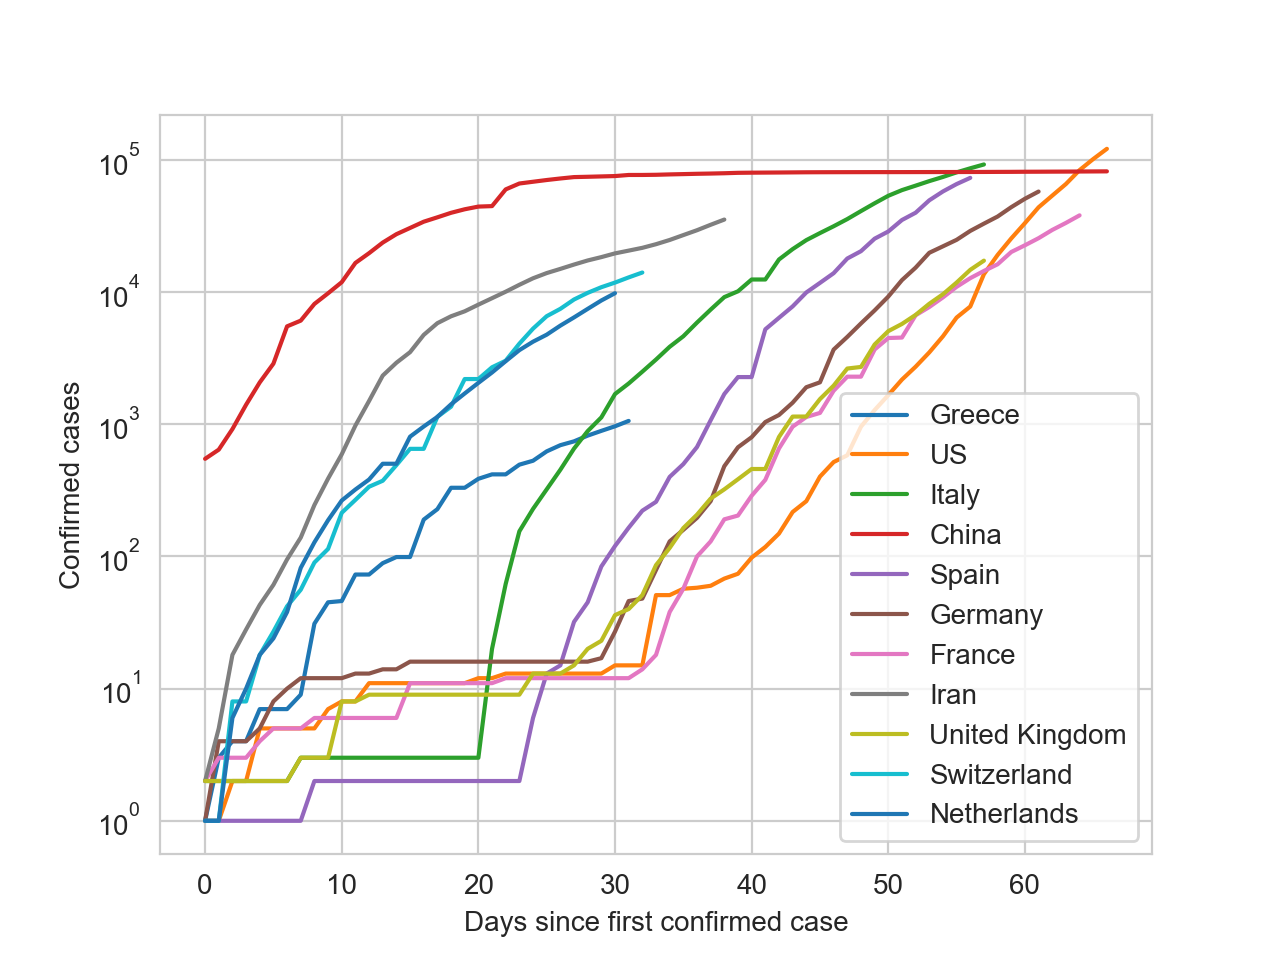

In [11]:
%matplotlib notebook

countries = top_cases
def plot_confirmed_cases(df, countries):
    g = sns.lineplot(df['Day'], df['Greece'], label='Greece')
    #sns.lineplot(df['Day'], df['notChina'], label='notChina')
    for country in countries:
        sns.lineplot(df['Day'], df[country], label=country)
    g.set(xlabel='Days since first confirmed case', ylabel='Confirmed cases')
    g.set_yscale("log")
    plt.legend()
 
plot_confirmed_cases(df_cases, countries)

<IPython.core.display.Javascript object>


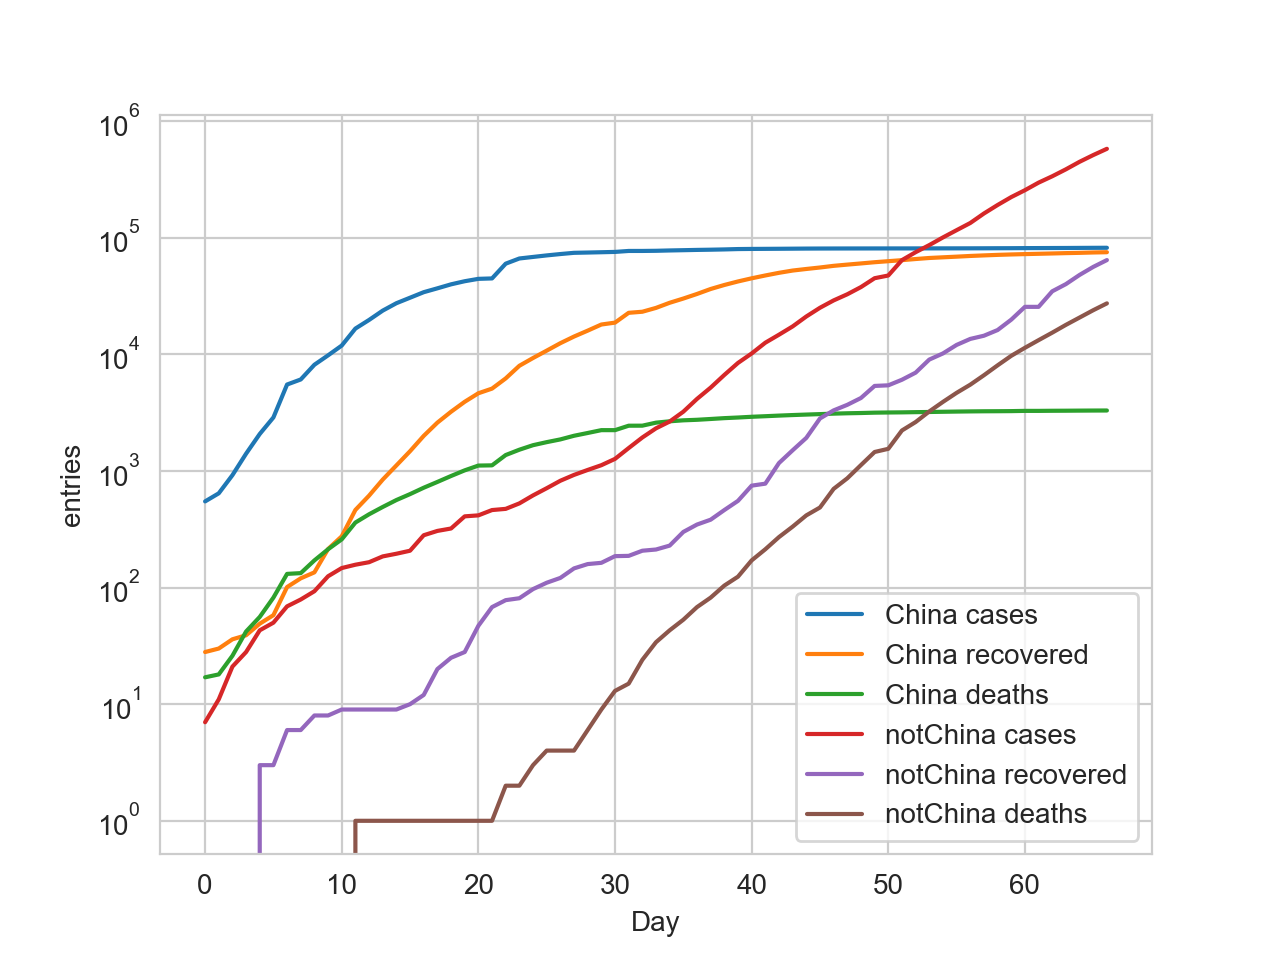

In [12]:
%matplotlib notebook

def plot_case_death_recovery(country):
    g = sns.lineplot(df_cases['Day'], df_cases[country], label=country+' cases')
    sns.lineplot(df_recoveries['Day'], df_recoveries[country], label=country+' recovered')
    sns.lineplot(df_deaths['Day'], df_deaths[country], label=country+' deaths')
    g.set(ylabel='entries')
    g.set_yscale("log")
    plt.legend()

plot_case_death_recovery('China')
plot_case_death_recovery('notChina')

In [ ]:
%matplotlib notebook

def sigmoid(x, x0, k, a, c):
     y = a / (1 + np.exp(-k*(x-x0))) + c
     return y

xdata, ydata = df_cases['Day'], df_cases['China']
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0=(1.0, -1.0, 1.0, 0.0))
print ("Fit:")
print ("x0 =", popt[0])
print "k  =", popt[1]
print "a  =", popt[2]
print "c  =", popt[3]
print "Asymptotes are", popt[3], "and", popt[3] + popt[2] 

print popt

x = np.linspace(-1, 50, 50)
y = sigmoid(x, *popt)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit')
pylab.ylim(0, 100000)
pylab.legend(loc='best')
pylab.show()

In [ ]:
%matplotlib notebook

def func(x, a, b, c):
    return a * np.exp(b * x) + c

def fit_cases_data(country, func, df):
    firstday = 0
    lastday = df[country].dropna().shape[0]

    xdata = df['Day'][(df['Day']>=firstday) & (df['Day']<lastday)]
    ydata = df[country][(df['Day']>=firstday) & (df['Day']<lastday)]
    
    plt.plot(xdata, ydata, 'bo', label='data')

    popt, pcov = curve_fit(func, xdata, ydata, [0.1,0.1,0.1], bounds=[[-100, -100, 0],[100, 100, 100]])
    print(popt)
    print("covariance matrix")
    print(pcov)
    x = np.linspace(firstday, lastday+5 , 100)
    plt.plot(x, func(x, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

    perr=np.sqrt(np.diag(pcov)) #standard errors
    plt.plot(x,func(x, *popt+perr), 'g')
    plt.plot(x,func(x, *popt-perr), 'g')

    plt.xlabel('days since first case')
    plt.ylabel('number of confirmed cases')
    plt.legend()
    #plt.yscale('log')
    plt.show()


In [ ]:
%matplotlib notebook

fit_cases_data("Germany", func, df_deaths)

In [ ]:
def fit_cases_data_sigmoid(country, func, df):
    firstday = 0
    lastday = df[country].dropna().shape[0]

    xdata = df['Day'][(df['Day']>=firstday) & (df['Day']<lastday)]
    ydata = df[country][(df['Day']>=firstday) & (df['Day']<lastday)]
    
    plt.plot(xdata, ydata, 'bo', label='data')

    popt, pcov = curve_fit(func, xdata, ydata, [50.0, 0, -1e3, 1e3])
    print(popt)
    print("covariance matrix")
    print(pcov)
    x = np.linspace(firstday, lastday+10 , 100)
    plt.plot(x, func(x, *popt), 'r-',label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))

    perr=np.sqrt(np.diag(pcov)) #standard errors
    plt.plot(x,func(x, *popt+perr), 'g')
    plt.plot(x,func(x, *popt-perr), 'g')

    plt.xlabel('days since first case')
    plt.ylabel('number of confirmed cases')
    plt.legend()
    #plt.yscale('log')
    plt.show()

In [ ]:
%matplotlib notebook

fit_cases_data_sigmoid("Germany", sigmoid, df_cases)